In [2]:
#mask
import json
import cv2
import os
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import keras
from keras.preprocessing import image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models

from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical

from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten 
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import to_categorical
import xml.etree.ElementTree as ET
from tensorflow.keras.callbacks import TensorBoard

from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [1]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.


In [1]:
import keras
model_name = "mutiple_Conv1D_8_inputs_scaled_modified"
model = keras.models.load_model("D:/Project2022/models/"+model_name+".h5")

In [3]:
import time
model_name = "6_inputs_scaled_kfold"
NAME = model_name+"-{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir = 'logs/{}'.format(NAME))

In [4]:
CATEGORIES = ["covid", "normal"]
DATADIR = "D:/Project2022/res/split_dataset/scaled_resized/train"

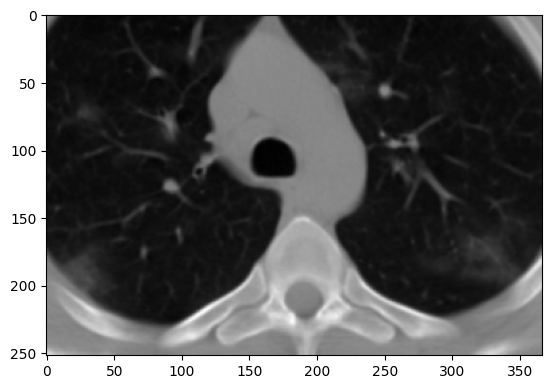

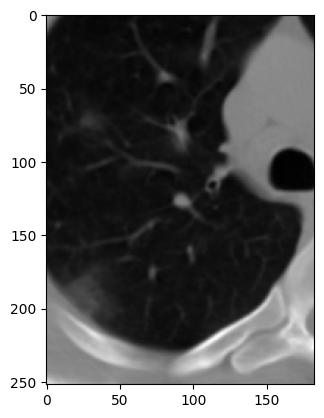

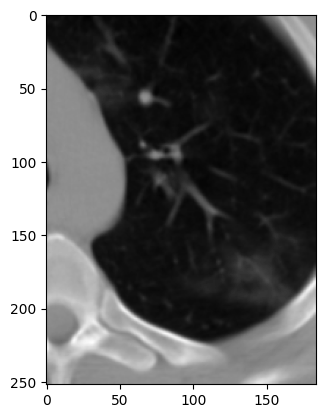

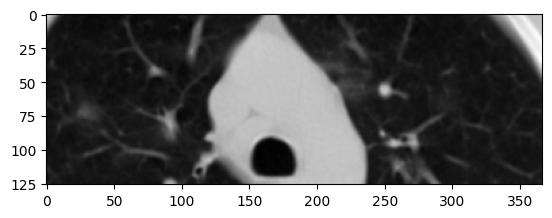

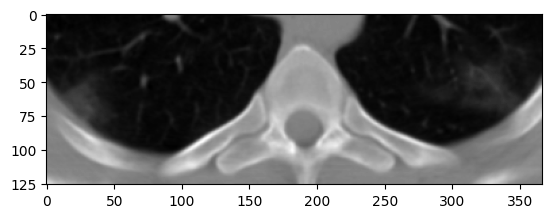

In [5]:
for categoty in CATEGORIES:
    path = os.path.join(DATADIR, categoty)  # path to Covid or Nprmal
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        #img_array = cv2.resize(img_array, (512,512), interpolation= cv2.INTER_LINEAR)
        plt.imshow(img_array, cmap="gray")
        plt.show()

        #mid_h = int(img_array.shape[1]/4)
        #mid_v = int(img_array.shape[0]/4)


        #left half
        LH_img = img_array[: , :int(img_array.shape[1]/2)]
        plt.imshow(LH_img, cmap="gray")
        plt.show()
        
        #Right half
        RH_img = img_array[: , int(img_array.shape[1]/2):]
        plt.imshow(RH_img, cmap="gray")
        plt.show()

        # mid vertical
        #mid_ver = img_array[:, int((img_array.shape[1]/2)-mid_h):int((img_array.shape[1]/2)+mid_h)]
        #plt.imshow(mid_ver, cmap="gray")
        #plt.show()

        #top half
        TC_img = img_array[:int(img_array.shape[0]/2) , :]
        plt.imshow(TC_img, cmap="gray")
        plt.show()

        #bottom half
        BC_img =  img_array[int(img_array.shape[0]/2): , :]
        plt.imshow(BC_img, cmap="gray")
        plt.show()

        #mid horizontal
        #mid_hor = img_array[int((img_array.shape[0]/2)-mid_v):int((img_array.shape[0]/2)+mid_v), :]
        #plt.imshow(mid_hor, cmap="gray")
        #plt.show()


        break
    break

In [6]:
def pre_process_dataset(dataset_path):

    df_data = pd.DataFrame()
    #raw_image = []
    row_sum = []
    coloumn_sum = []
    
    LH_sum = []
    #Row_mid = []
    RH_sum = []
    
    TC_sum = []
    #Col_mid = []
    BC_sum =[]

    label = []

    for categoty in CATEGORIES:
        path = os.path.join(dataset_path, categoty)  
        
        class_num = CATEGORIES.index(categoty)
        

        print("Loading dataset: class",categoty)
        for img in tqdm(os.listdir(path)):

            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                #img_array = cv2.resize(img_array, (512,512), interpolation= cv2.INTER_LINEAR)
                row = img_array.sum(axis=0)
                coloumn = img_array.sum(axis=1)
                #mid_h = int(img_array.shape[1]/4)
                #mid_v = int(img_array.shape[0]/4)

                #Global inputs
                row_sum.append(row)
                coloumn_sum.append(coloumn)

                #row inputs
                LH_img = img_array[: , :int(img_array.shape[1]/2)]
                LH_sum.append(LH_img.sum(1))

                #row_mid = img_array[:, int((img_array.shape[1]/2)-mid_h):int((img_array.shape[1]/2)+mid_h)]
                #Row_mid.append(row_mid.sum(1))

                RH_img = img_array[: , int(img_array.shape[1]/2):]
                RH_sum.append(RH_img.sum(1))

                #coloumn inputs
                TC_img = img_array[:int(img_array.shape[0]/2) , :]
                TC_sum.append(TC_img.sum(0))

                #col_mid = img_array[int((img_array.shape[0]/2)-mid_v):int((img_array.shape[0]/2)+mid_v), :]
                #Col_mid.append(col_mid.sum(0)) 

                BC_img = img_array[int(img_array.shape[0]/2): , :]
                BC_sum.append(BC_img.sum(0))

                
                #raw_image.append(img_array)             

                label.append(class_num)
                
            except Exception as e:
                pass
    
    #df_data["raw data"] = raw_image
    df_data["row_sum"] = row_sum
    df_data["coloumn_sum"] = coloumn_sum

    df_data["LH_sum"] = LH_sum
    #df_data["Row_mid"] = Row_mid
    df_data["RH_sum"] = RH_sum


    df_data["TC_sum"] = TC_sum
    #df_data["Col_mid"] = Col_mid
    df_data["BC_sum"] = BC_sum

    df_data["label"] = label
    

    return df_data

In [7]:
dataset_df = pre_process_dataset(DATADIR)

Loading dataset: class covid


  0%|          | 0/5719 [00:00<?, ?it/s]

Loading dataset: class normal


  0%|          | 0/5514 [00:00<?, ?it/s]

In [9]:
dataset_df.head(-1)

,row_sum,coloumn_sum,LH_sum,RH_sum,TC_sum,BC_sum,label
0,"[12868, 12523, 12192, 11946, 11733, 11461, 112...","[10936, 10780, 10654, 10588, 10564, 10593, 105...","[4446, 4405, 4387, 4379, 4388, 4477, 4595, 472...","[6490, 6375, 6267, 6209, 6176, 6116, 5984, 585...","[3074, 2891, 2741, 2649, 2570, 2401, 2218, 208...","[9794, 9632, 9451, 9297, 9163, 9060, 8987, 891...",0
1,"[36184, 36414, 36553, 36656, 36729, 36860, 371...","[55967, 56111, 56305, 56494, 56637, 56789, 569...","[28307, 28294, 28285, 28291, 28285, 28281, 283...","[27660, 27817, 28020, 28203, 28352, 28508, 286...","[19029, 19057, 19124, 19231, 19279, 19342, 194...","[17155, 17357, 17429, 17425, 17450, 17518, 176...",0
2,"[37746, 37912, 38173, 38320, 38385, 38422, 385...","[54067, 53512, 53303, 53342, 52215, 50208, 484...","[28769, 28776, 29083, 29425, 28572, 27101, 261...","[25298, 24736, 24220, 23917, 23643, 23107, 223...","[18459, 18567, 18753, 18848, 18914, 18951, 190...","[19287, 19345, 19420, 19472, 19471, 19471, 195...",0
3,"[26314, 26321, 26459, 26562, 26715, 26737, 267...","[35673, 35586, 35684, 35815, 35816, 35884, 360...","[17737, 17688, 17732, 17837, 17884, 17923, 180...","[17936, 17898, 17952, 17978, 17932, 17961, 180...","[12822, 12782, 12842, 12911, 12994, 13044, 130...","[13492, 13539, 13617, 13651, 13721, 13693, 137...",0
4,"[24059, 24365, 24695, 24737, 24813, 24900, 254...","[29136, 28924, 28811, 28714, 28914, 29077, 292...","[10637, 10497, 10486, 10507, 10558, 10533, 104...","[18499, 18427, 18325, 18207, 18356, 18544, 187...","[11508, 11667, 11837, 11914, 12066, 12193, 128...","[12551, 12698, 12858, 12823, 12747, 12707, 126...",0
...,...,...,...,...,...,...,...
11227,"[37957, 38492, 38926, 38919, 38797, 38872, 388...","[49742, 48901, 48038, 46953, 45831, 45094, 444...","[25037, 24655, 24290, 23831, 23235, 22811, 226...","[24705, 24246, 23748, 23122, 22596, 22283, 218...","[18940, 19404, 19926, 19968, 19831, 19827, 197...","[19017, 19088, 19000, 18951, 18966, 19045, 190...",1
11228,"[33625, 34209, 34516, 34453, 34423, 34555, 345...","[43491, 42926, 42867, 42943, 42969, 43020, 431...","[19413, 18631, 18368, 18313, 18311, 18357, 183...","[24078, 24295, 24499, 24630, 24658, 24663, 247...","[16142, 16717, 16982, 16863, 16801, 16924, 168...","[17483, 17492, 17534, 17590, 17622, 17631, 176...",1
11229,"[38357, 37798, 37141, 36709, 36424, 35781, 347...","[46906, 43435, 41254, 40437, 40145, 39932, 397...","[25188, 22625, 20879, 20238, 20065, 19957, 198...","[21718, 20810, 20375, 20199, 20080, 19975, 198...","[18821, 18462, 17871, 17274, 16790, 16434, 162...","[19536, 19336, 19270, 19435, 19634, 19347, 184...",1
11230,"[33905, 33854, 33735, 33742, 33874, 34120, 343...","[54530, 54574, 54679, 54778, 54979, 55026, 551...","[27877, 27902, 27880, 27852, 27921, 27921, 278...","[26653, 26672, 26799, 26926, 27058, 27105, 273...","[18359, 18386, 18378, 18409, 18484, 18625, 187...","[15546, 15468, 15357, 15333, 15390, 15495, 155...",1


In [8]:
df_train, df_val = train_test_split(dataset_df, test_size=0.2, random_state=0)

In [9]:
df_train["label"].value_counts()

0    4601
1    4385
Name: label, dtype: int64

In [10]:
print("No of Training samples:",len(df_train))
print("No of Validation samples:",len(df_val))

No of Training samples: 8986
No of Validation samples: 2247


In [11]:
df_train["row_sum"][0].shape

(367,)

In [12]:
from sklearn import preprocessing

def process_data(dataset_df):
    
    row = dataset_df["row_sum"].values
    coloumn = dataset_df["coloumn_sum"].values

    LH = dataset_df["LH_sum"].values
    #Row_mid = dataset_df["Row_mid"].values
    RH = dataset_df["RH_sum"].values


    TC = dataset_df["TC_sum"].values
    #Col_mid = dataset_df["Col_mid"].values
    BC = dataset_df["BC_sum"].values

    # global
    X1 = [img.tolist() for img in row]
    X2 = [img.tolist() for img in coloumn]

    #row
    X3 = [img.tolist() for img in LH]
    #X_row_mid = [img.tolist() for img in Row_mid]
    X4 = [img.tolist() for img in RH]

    #coloumn
    X5 = [img.tolist() for img in TC]
    #X_col_mid = [img.tolist() for img in Col_mid]
    X6 = [img.tolist() for img in BC]


    X1 = np.array(X1)
    X2 = np.array(X2)

    X3 = np.array(X3)
    #X_row_mid = np.array(X_row_mid)
    X4 = np.array(X4)


    X5 = np.array(X5)
    #X_col_mid = np.array(X_col_mid)
    X6 = np.array(X6)

    #normalize the inputs
    X1 = preprocessing.normalize(X1)
    X2 = preprocessing.normalize(X2)

    X3 = preprocessing.normalize(X3)
    #X_row_mid = preprocessing.normalize(X_row_mid)
    X4 = preprocessing.normalize(X4)

    X5 = preprocessing.normalize(X5)
    #X_col_mid = preprocessing.normalize(X_col_mid)
    X6 = preprocessing.normalize(X6)

    #reshape the inputs
    X1 = np.expand_dims(X1, axis=-1)
    X2 = np.expand_dims(X2, axis=-1)

    X3 = np.expand_dims(X3, axis=-1)
    #X_row_mid = np.expand_dims(X_row_mid, axis=-1)
    X4 = np.expand_dims(X4, axis=-1)

    X5 = np.expand_dims(X5, axis=-1)
    #X_col_mid = np.expand_dims(X_col_mid, axis=-1)
    X6 = np.expand_dims(X6, axis=-1)



    y = np.array(dataset_df["label"].values)
    y = np.expand_dims(y, axis=-1)


    print("X1 shape", X1.shape)
    print("X2 shape", X2.shape)

    print("X3 shape", X3.shape)
    #print("Mid rows shape", X_row_mid.shape)
    print("X4 shape", X4.shape)

    print("X5 shape", X5.shape)
    #print("Mid Cols shape", X_col_mid.shape)
    print("X6 shape", X6.shape)

    print("y shape", y.shape)

    return X1, X2, X3, X4, X5, X6, y

In [13]:
print("Training samples:")
X1_train, X2_train, X3_train, X4_train, X5_train, X6_train, Y_train = process_data(df_train)

print("\nValidation samples:")
X1_val, X2_val, X3_val, X4_val, X5_val, X6_val, Y_val = process_data(df_val)


Training samples:
X1 shape (8986, 367, 1)
X2 shape (8986, 252, 1)
X3 shape (8986, 252, 1)
X4 shape (8986, 252, 1)
X5 shape (8986, 367, 1)
X6 shape (8986, 367, 1)
y shape (8986, 1)

Validation samples:
X1 shape (2247, 367, 1)
X2 shape (2247, 252, 1)
X3 shape (2247, 252, 1)
X4 shape (2247, 252, 1)
X5 shape (2247, 367, 1)
X6 shape (2247, 367, 1)
y shape (2247, 1)


In [14]:
def conv1D_layer(input, nodes):
    #Input(shape=(367,1))
    #input_layer = Input(shape=inputSize)
    #kernel size- 5
    # nodes - 16
    conv1 = Conv1D(nodes, kernel_size=5, activation='relu')(input)
    drop1 = Dropout(0.25)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat = Flatten()(pool1)
    return flat

## Modified

In [15]:
# first input model
row = Input(shape=(367,1))
flat_row = conv1D_layer(row, 64)

# second input model
col = Input(shape=(252,1))
flat_col = conv1D_layer(col, 64)

#####################################################################

LH = Input(shape=(252,1))
flat3 = conv1D_layer(LH, 64)

#row_mid = Input(shape=(252,1))
#flat4 = conv1D_layer(row_mid, 16)

RH = Input(shape=(252,1))
flat5 = conv1D_layer(RH, 64)


TC = Input(shape=(367,1))
flat6 = conv1D_layer(TC, 64)

#col_mid = Input(shape=(367,1))
#flat7 = conv1D_layer(col_mid, 16)

BC = Input(shape=(367,1))
flat8 = conv1D_layer(BC, 64)


merge_all = concatenate([flat_row, flat_col, flat3, flat5, flat6, flat8])
#32
hidden_all_1 = Dense(32, activation='relu')(merge_all)
#16
hidden_all_2 = Dense(16, activation='relu')(hidden_all_1)

output = Dense(1, activation='sigmoid')(hidden_all_2)
model = Model(inputs=[row, col, LH,  RH, TC, BC], outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# summarize layers
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 367, 1)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 252, 1)]     0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 252, 1)]     0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 252, 1)]     0           []                               
                                                                                              

In [16]:

BATCH_SIZE = 128
EPOCHS = 500
history = model.fit(
    [X1_train, X2_train, X3_train,  X4_train, X5_train,  X6_train],
    Y_train,
    BATCH_SIZE,
    EPOCHS,
    validation_data=([X1_val, X2_val, X3_val,  X4_val, X5_val,  X6_val], Y_val),
    callbacks=[tensorboard])

model.save("D:/Project2022/models/less_complex/"+model_name+".h5")

Epoch 1/500
71/71 [==============================] - 10s 35ms/step - loss: 0.6308 - accuracy: 0.6670 - val_loss: 0.6021 - val_accuracy: 0.6920
Epoch 2/500
71/71 [==============================] - 2s 29ms/step - loss: 0.5613 - accuracy: 0.7251 - val_loss: 0.5349 - val_accuracy: 0.7437
Epoch 3/500
71/71 [==============================] - 2s 26ms/step - loss: 0.4830 - accuracy: 0.7712 - val_loss: 0.4899 - val_accuracy: 0.7793
Epoch 4/500
71/71 [==============================] - 2s 25ms/step - loss: 0.4458 - accuracy: 0.7938 - val_loss: 0.4335 - val_accuracy: 0.8171
Epoch 5/500
71/71 [==============================] - 2s 26ms/step - loss: 0.4222 - accuracy: 0.8074 - val_loss: 0.4123 - val_accuracy: 0.8238
Epoch 6/500
71/71 [==============================] - 2s 25ms/step - loss: 0.4025 - accuracy: 0.8207 - val_loss: 0.4222 - val_accuracy: 0.8255
Epoch 7/500
71/71 [==============================] - 2s 25ms/step - loss: 0.3887 - accuracy: 0.8317 - val_loss: 0.4038 - val_accuracy: 0.8313
Epoch

In [3]:
import keras
model_name = "mutiple_Conv1D_8_inputs_scaled_modified"
model = keras.models.load_model("D:/Project2022/models/"+model_name+".h5")

In [16]:
model_name

'mutiple_Conv1D_8_inputs_scaled_modified'

In [1]:
import keras
model_name = "6_inputs_raw_5fold"
model = keras.models.load_model("D:/Project2022/models/less_complex/"+model_name+".h5")

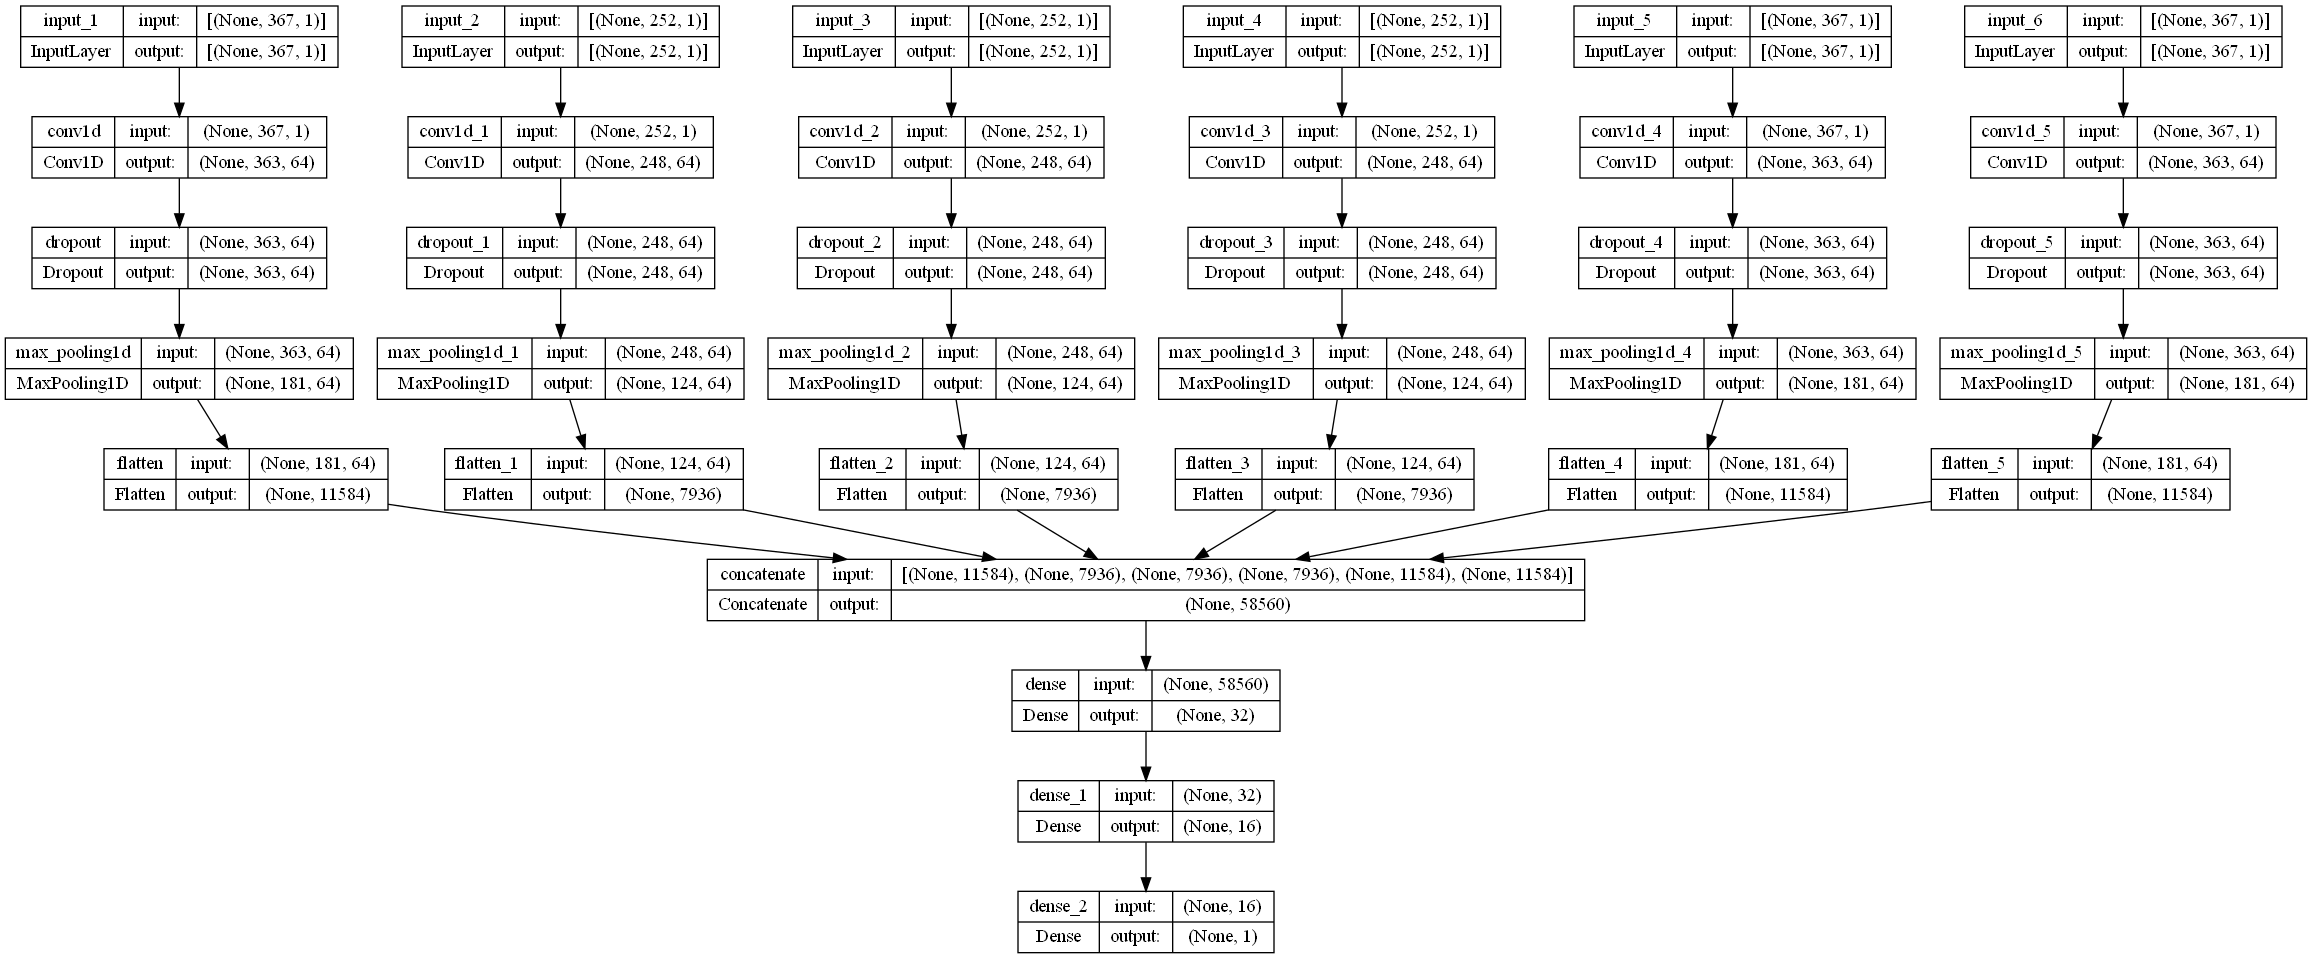

In [2]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file=model_name + ".png", show_shapes=True, show_layer_names=True)

# Evaluate the Model using test data

In [17]:
Test_DATADIR = "D:/Project2022/res/split_dataset/scaled_resized/test"
dataset_df = pre_process_dataset(Test_DATADIR)


Loading dataset: class covid


  0%|          | 0/1430 [00:00<?, ?it/s]

Loading dataset: class normal


  0%|          | 0/1379 [00:00<?, ?it/s]

In [18]:
print("No of test sample:", len(dataset_df))

No of test sample: 2809


In [19]:
X1_test, X2_test, X3_test, X4_test, X5_test, X6_test, Y_test = process_data(dataset_df)

X1 shape (2809, 367, 1)
X2 shape (2809, 252, 1)
X3 shape (2809, 252, 1)
X4 shape (2809, 252, 1)
X5 shape (2809, 367, 1)
X6 shape (2809, 367, 1)
y shape (2809, 1)


In [20]:
# test loss, test accuracy
accuracy = model.evaluate([X1_test, X2_test, X3_test, X4_test, X5_test, X6_test], Y_test, batch_size=100, verbose=0)

In [21]:
print("Test acuuracy", accuracy[1])
print("Test loss", accuracy[0])

Test acuuracy 0.9355642795562744
Test loss 0.282659649848938


In [22]:
#y_pred = model.predict_classes(X_test)
y_pred = (model.predict([X1_test, X2_test, X3_test, X4_test, X5_test, X6_test]) > 0.5).astype("int32")

88/88 [==============================] - 1s 6ms/step


In [23]:
print(classification_report(Y_test, y_pred, target_names=["covid", "Normal"]))

              precision    recall  f1-score   support

       covid       0.95      0.93      0.94      1430
      Normal       0.92      0.95      0.94      1379

    accuracy                           0.94      2809
   macro avg       0.94      0.94      0.94      2809
weighted avg       0.94      0.94      0.94      2809



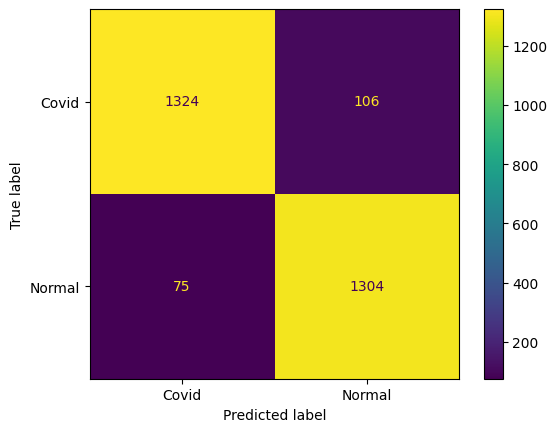

In [24]:
cm = confusion_matrix(Y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Covid","Normal"])
disp.plot()
plt.show()
